# Takehome test trashnet classification

by Machffud Tra H. V (machffud.tra@ui.ac.id)



In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install datasets

## Setup & Helpers

In [2]:
!pip install -Uq fastai einops ml_collections
!pip install wandb -qU

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 61.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.0/289.0 kB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 10.1 MB/s eta 0:00:00


In [3]:
!nvidia-smi

Fri May 24 14:19:59 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   38C    P8              12W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
import os
import glob
import functools
import wandb

from ml_collections import config_dict

import numpy as np
from einops.layers.torch import Rearrange

from PIL import Image
from matplotlib import pyplot as plt

from fastai.vision.all import *
from torchvision.transforms import RandAugment

from sklearn.metrics import classification_report, accuracy_score

**IMPORTANT**: Adjust training configuration and seed below:

In [5]:
wandb.login()


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [7]:
cfg = config_dict.ConfigDict()
cfg.use_augmentations = True
cfg.do_export_clf_results = True
cfg.bs = 64
cfg.data_path = "data"
wandb.init(project="trashnet-classification",
        config={key:cfg[key] for key in cfg},
        )
# To ensure reproducibility
# Huge variance can occur (between seeds) due to
# random validation splits and the stochastic nature of the training
set_seed(18264)

wandb: Currently logged in as: machffud (ml-maung). Use `wandb login --relogin` to force relogin


In [17]:
# Analysis Helpers
def assess_test_performance(learner, tdl, vocab):
    preds = learner.get_preds(dl=tdl, with_decoded=True)
    print(classification_report(*preds[1:], digits=4, target_names=vocab))
    wandb.log({"classification report":classification_report(*preds[1:], digits=4, target_names=vocab)})

def assess_test_performance_with_tta(learner, tdl, vocab):
    preds = learner.tta(dl=tdl)
    print(classification_report(preds[1], preds[0].argmax(1), digits=4, target_names=vocab))
    wandb.log({"classification report with tta":classification_report(preds[1], preds[0].argmax(1), digits=4, target_names=vocab)})

def get_validation_performance(learner, dls):
    """Returns accuracy for valid set"""
    preds = learner.get_preds(dl=dls.valid, with_decoded=True)
    return accuracy_score(*preds[1:])

In [9]:
class RandAugmentTransform(RandTransform):
    "A fastai transform handler/wrapper for RandAugment (https://arxiv.org/abs/1909.13719)"
    split_idx, order = None, 2
    def __init__(self): store_attr()

    def before_call(self, b, split_idx):
        self.idx = split_idx
        self.aug = RandAugment()

    def encodes(self, img: PILImage):
        return self.aug(img) if self.idx == 0 else img

## Data

In [10]:
# %cd drive/MyDrive
# !ls trashnetDataset
# #!cp -r trashnetDataset/data adamata
# !ls adamata
# %cd adamata

/content/drive/MyDrive
data  data.zip
data  data.zip	results
/content/drive/MyDrive/adamata


In [ ]:
import os
import shutil
from datasets import load_dataset
from sklearn.model_selection import train_test_split

# Download the dataset
dataset = load_dataset('garythung/trashnet')

def add_image_name(dataset):
    label_counts = {}

    def generate_image_name(example):
        label = example['label']
        if label not in label_counts:
            label_counts[label] = 0
        image_name = f"{label}_{label_counts[label]}"
        label_counts[label] += 1
        example['image_name'] = image_name
        return example
    dataset = dataset.map(generate_image_name)
    return dataset
dataset["train"] = add_image_name(dataset["train"])
# Create directories for train and test datasets
os.makedirs('data/train', exist_ok=True)
os.makedirs('data/test', exist_ok=True)

# Get the dataset in dictionary format

dataset_dict = dataset['train'].train_test_split(test_size=0.2, stratify_by_column='label')



Prepare data files (rename and splitting). Stratified splitting to train and test with ratio 4:1.

In [ ]:

# Function to save the split dataset to disk
def save_dataset(split_dataset, split_name):
    for item in split_dataset:
        label = item['label']
        img = item['image']

        # Create directories for each label
        label_dir = os.path.join('data', split_name, str(label))
        os.makedirs(label_dir, exist_ok=True)

        # Save image
        img_path = os.path.join(label_dir, f"{item['image_name']}.jpg")
        img.save(img_path)

# Save the train and test datasets
save_dataset(dataset_dict['train'], 'train')
save_dataset(dataset_dict['test'], 'test')

print("Dataset has been split and saved successfully.")

In [11]:
!find data -maxdepth 2 -type d -ls

      266      4 drwx------   2 root     root         4096 May 24 02:56 data
      268      4 drwx------   2 root     root         4096 May 23 23:43 data/test
      271      4 drwx------   2 root     root         4096 May 24 03:19 data/test/4
      272      4 drwx------   2 root     root         4096 May 24 03:20 data/test/3
      273      4 drwx------   2 root     root         4096 May 24 03:21 data/test/0
      274      4 drwx------   2 root     root         4096 May 24 03:22 data/test/1
      275      4 drwx------   2 root     root         4096 May 24 03:22 data/test/2
      276      4 drwx------   2 root     root         4096 May 24 03:23 data/test/5
      269      4 drwx------   2 root     root         4096 May 24 02:56 data/train
      277      4 drwx------   2 root     root         4096 May 23 23:43 data/train/0
      278      4 drwx------   2 root     root         4096 May 23 23:43 data/train/5
      279      4 drwx------   2 root     root         4096 May 23 23:43 data/train/3

Set up transforms and augmentations. As default, we will use Imagenet mean/std.dev (arbitrary choice, we can also use `[0.5, 0.5, 0.5]`) to normalize our images. To enhance robustness and prevent overfitting, we use the following augmentations:
1. Random Resize Then Crop - preserving the image size 224x224 and to capture smaller or sections of the image
2. [RandAugment](https://arxiv.org/abs/1909.13719) - SOTA set of augmentation (pretty standard in SOTA models in addition to CutMix and MixUp)

We do not use CutMix or MixUp to keep the model simple and the training fast (since getting the absolute best model performance is not the main objective here).

In [12]:
item_tfms = [RandomResizedCrop(224, min_scale=0.3), RandAugmentTransform()] if cfg.use_augmentations else []
batch_tfms = [Normalize.from_stats(*imagenet_stats)] # Just normalize to imagenet

Set up dataloaders for training, validation, and testing. For validation, we split it (20%) from the initial training set.

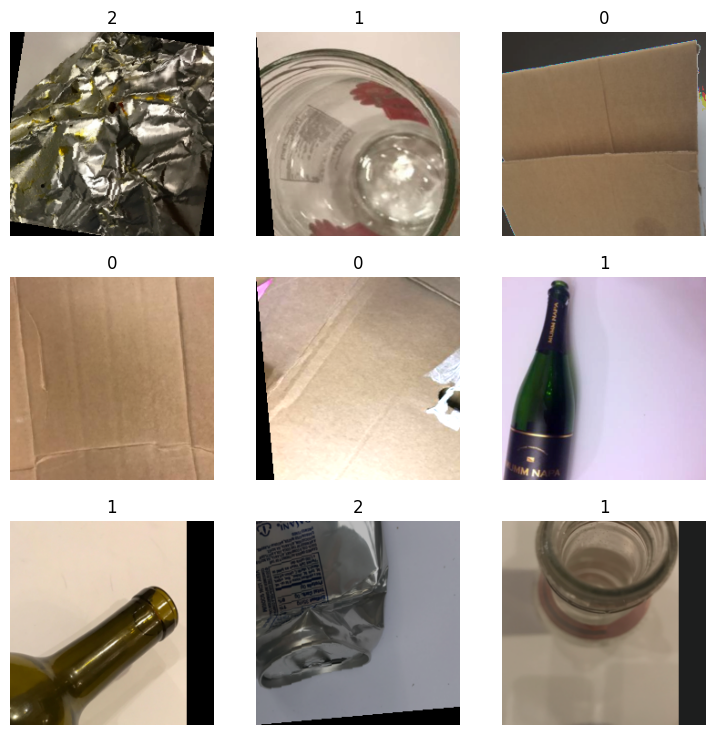

In [13]:
# Training and Validation Dataloaders
dls = ImageDataLoaders.from_folder(cfg.data_path, bs=cfg.bs, valid_pct=0.2, item_tfms=item_tfms, batch_tfms=batch_tfms)
dls.show_batch() # should show the effect of RandAugment

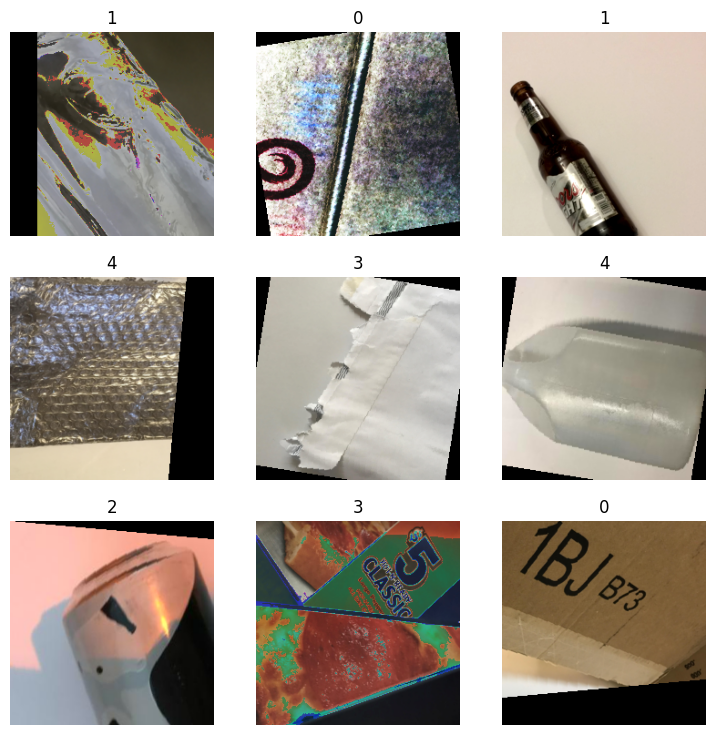

In [15]:
wandb.Table(dls.show_batch())

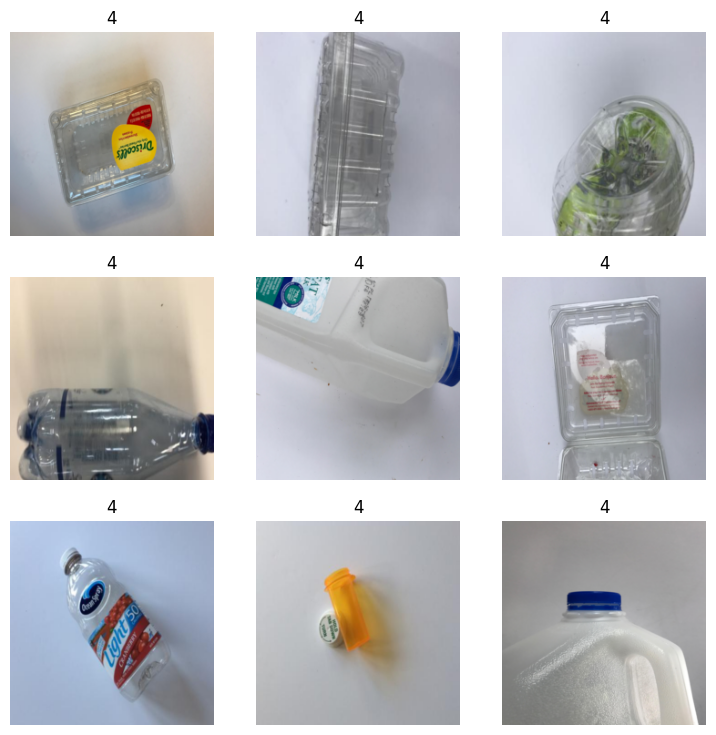

In [16]:
tdl = dls.test_dl(get_image_files(Path(cfg.data_path)/"test"), with_labels=True)
wandb.Table(tdl.show_batch()) # should not show RandAugment

## Modeling

We will create and evaluate Standard ResNet34


To downsample the image 4x, standard ResNet would utilize a 7x7 convolution layer with stride and padding combined with a max pool layer.
```python
# Standard
      self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
      self.bn1 = nn.BatchNorm2d(self.inplanes)
      self.gelu = nn.ReLU(inplace=True)
      self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

```


To train the models, we utilize the `AdamW` (default optimizer provided by fast.ai) with decoupled weight decay and the following parameters:
- `mom`: $β_{1}=0.9$
- `sqr_mom`: $β_{2}=0.99$
- `eps`: $ϵ=10^{-5}$
- `wd`: $λ=0.01$

For the initial learning rate, we use the LR finder algorithm described by Leslie Smith (https://arxiv.org/abs/1506.01186) to determine a good starting learning rate. For the training process themselves, we use a 3-stage training process with first, a linear training with constant learning rate (as determined by the algorithm) for about 24 epochs then continuing to a second stage with one-cycle scheduling for 24 epochs. To check (and hopefully ensures) convergence, we will 'train' the model for another 12 epochs. To ensure we get the best results, we will use `SaveModelCallback` provided by fastai to load the best model in the end.

As per usual with image classification, we use cross entropy loss as our loss function (specifically `CrossEntropyLossFlat` provided by fastai that is the same as `torch.nn.CrossEntropyLoss` except for automatically flattening inputs and targets). The inputs themselves are 3 channels 224x224 images (3x224x224) with batch size of 64 (64x3x224x224).

To ensure correctness, we will **train the models 5 times using different seeds**. Hence, this code/notebook below are meant to be demonstrative and the results demonstrated are not meant to be taken directly (since they are just 1 of 3 final results).

In [32]:
def start_train(learner, epochs=[24, 24, 12], tdl=tdl):
    def get_lr_():
        lr = learner.lr_find()
        plt.show()
        wandb.log({"best lr":plt.show()})
        print("Fit LR:", lr)
        wandb.log({"Fit LR":lr})
        return lr

    name = type(learner.model).__name__
    dls = learner.dls

    # start normal fit
    learner.fit(epochs[0], get_lr_())

    # start fit_one_cycle
    learner.fit_one_cycle(epochs[1], get_lr_())

    # convergence fit
    learner.fit_one_cycle(epochs[2], get_lr_())

    learner.save(name)
    print(f"Training done for {name}")

### ResNet Block

To start with, we use the following definition for a (basic) ResNet block. The only notable difference would be the change from ReLU to GELU to better conform with modern training practices.

In [19]:
# Adapted from https://pytorch.org/vision/stable/_modules/torchvision/models/resnet.html
class BasicResNetBlock(nn.Module):
    """Basic ResNet Block (no bottleneck) with GELU instead of RELU"""
    expansion: int = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample = None
    ) -> None:
        super().__init__()
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, padding=1, stride=stride, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.gelu = nn.GELU()
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, padding=1, stride=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.gelu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.gelu(out)

        return out

### Conventional ResNet-34

The code for ResNet34 below was directly taken from a commonly used implementation (`torchvision`) to ensure validity and adapted to remove extraneous bits unused.

In [21]:
# Adapted from https://pytorch.org/vision/stable/_modules/torchvision/models/resnet.html
class ResNet(nn.Module):
    def __init__(
        self,
        block,
        layers,
        num_classes = 6,
        zero_init_residual = True,
    ) -> None:
        super().__init__()

        self.inplanes = 64

        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.inplanes)
        self.gelu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, BasicResNetBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(
        self,
        block,
        planes: int,
        blocks: int,
        stride: int = 1,
    ) -> nn.Sequential:
        downsample = None
        if stride != 1 or self.inplanes != planes:
                downsample = nn.Sequential(
                    nn.Conv2d(self.inplanes, planes, 1, stride, bias=False),
                    nn.BatchNorm2d(planes),
                )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))

        self.inplanes = planes

        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x: Tensor) -> Tensor:
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.gelu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

In [22]:
resnet34 = ResNet(BasicResNetBlock, [3, 4, 6, 3])
r34_cbs = [EarlyStoppingCallback(monitor="f1_score", min_delta=0.001, patience=4), SaveModelCallback(monitor="f1_score", fname="r34", reset_on_fit=False)]
learner_resnet34 = Learner(dls, resnet34, metrics=[accuracy, F1Score(average="macro")], cbs=r34_cbs)

As can be seen from the model summary below, the inputs to the ResNet blocks are downsampled 4x from 224x224 to 56x56 by the `stem` (`Conv2d(7, stride=2, padding=3)` and `MaxPool2d(3, stride=2, padding=1)`).

In [29]:
wandb.watch(learner_resnet34.model)

[]

In [27]:
learner_resnet34.summary()

ResNet (Input shape: 64 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 112 x 112 
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 56 x 56   
MaxPool2d                                                      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
GELU                                                           
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
GELU                          

In [30]:
wandb.log({"Summary learner":learner_resnet34.summary()})

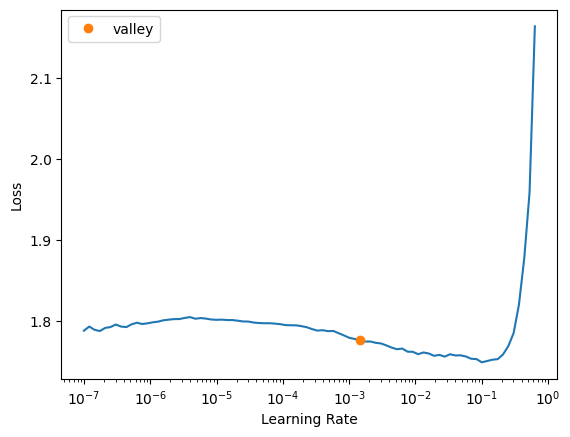

Fit LR: SuggestedLRs(valley=0.0014454397605732083)


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,1.641592,1.599606,0.363366,0.245636,01:37
1,1.488238,1.408873,0.389109,0.268628,00:43
2,1.394576,1.202365,0.509901,0.425483,00:44
3,1.326873,1.291235,0.554455,0.471751,00:43
4,1.279484,1.117590,0.593069,0.518406,00:44
5,1.222002,1.055541,0.609901,0.535636,00:43
6,1.179495,0.998887,0.636634,0.557867,00:44
7,1.148415,1.109446,0.654455,0.577907,00:46
8,1.128819,0.910085,0.670297,0.633753,00:43
9,1.107472,0.955428,0.637624,0.627019,00:45


Better model found at epoch 0 with f1_score value: 0.24563569913271333.
Better model found at epoch 1 with f1_score value: 0.26862838454378485.
Better model found at epoch 2 with f1_score value: 0.42548314077686666.
Better model found at epoch 3 with f1_score value: 0.4717512935001437.
Better model found at epoch 4 with f1_score value: 0.5184056551200786.
Better model found at epoch 5 with f1_score value: 0.5356364785508841.
Better model found at epoch 6 with f1_score value: 0.5578670766473933.
Better model found at epoch 7 with f1_score value: 0.5779065291309625.
Better model found at epoch 8 with f1_score value: 0.6337533561231993.
Better model found at epoch 12 with f1_score value: 0.6729315954103088.
Better model found at epoch 15 with f1_score value: 0.7290107224992859.
Better model found at epoch 18 with f1_score value: 0.7352219151869481.
No improvement since epoch 18: early stopping


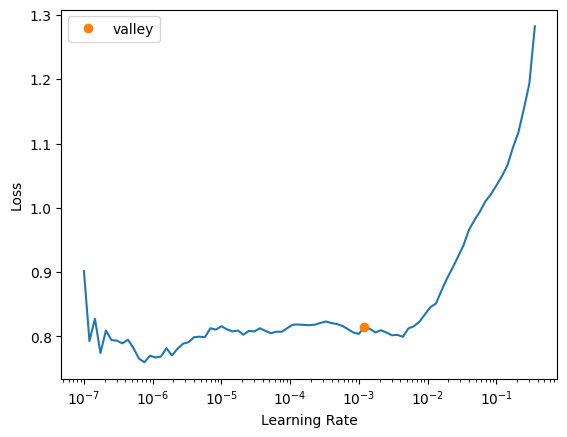

Fit LR: SuggestedLRs(valley=0.0012022644514217973)


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.762033,0.575010,0.792079,0.763431,00:49
1,0.737789,0.513663,0.818812,0.795897,00:48
2,0.710934,0.596849,0.781188,0.745284,00:49
3,0.774493,0.676840,0.753465,0.726014,00:48
4,0.751476,0.557395,0.811881,0.769839,00:49
5,0.750225,0.535610,0.814851,0.791461,00:48


Better model found at epoch 0 with f1_score value: 0.7634306931771712.
Better model found at epoch 1 with f1_score value: 0.7958968272256656.
No improvement since epoch 1: early stopping


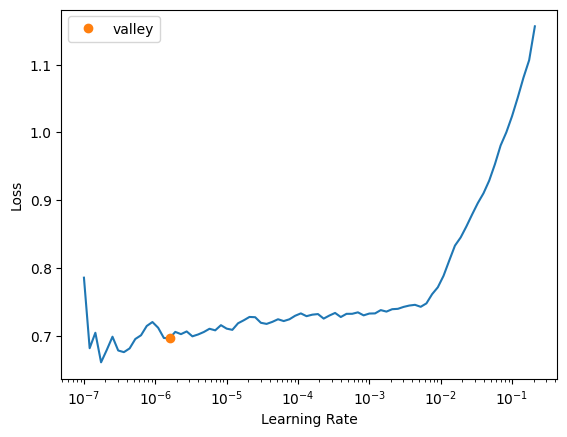

Fit LR: SuggestedLRs(valley=1.5848931980144698e-06)


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.700009,0.505304,0.816832,0.798173,00:41
1,0.702520,0.501056,0.817822,0.797654,00:38
2,0.697481,0.507929,0.817822,0.800569,00:37
3,0.701275,0.505704,0.822772,0.804325,00:38
4,0.721688,0.503992,0.820792,0.801094,00:37
5,0.712231,0.499785,0.820792,0.803986,00:39
6,0.691942,0.505634,0.815842,0.796021,00:39


Better model found at epoch 0 with f1_score value: 0.7981726712276439.
Better model found at epoch 2 with f1_score value: 0.8005693728434022.
Better model found at epoch 3 with f1_score value: 0.8043251884374993.


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.700009,0.505304,0.816832,0.798173,00:41
1,0.702520,0.501056,0.817822,0.797654,00:38
2,0.697481,0.507929,0.817822,0.800569,00:37
3,0.701275,0.505704,0.822772,0.804325,00:38
4,0.721688,0.503992,0.820792,0.801094,00:37
5,0.712231,0.499785,0.820792,0.803986,00:39
6,0.691942,0.505634,0.815842,0.796021,00:39
7,0.685759,0.497095,0.820792,0.801926,00:38


No improvement since epoch 3: early stopping
Training done for ResNet


In [33]:
start_train(learner_resnet34)

In [ ]:
assess_test_performance(learner_resnet34, tdl, dls.vocab)
assess_test_performance_with_tta(learner_resnet34, tdl, dls.vocab)

## Analysis

In [20]:
!mkdir -p results

In [34]:
def evaluate(learner, dl=tdl, vocab=dls.vocab):
    name = type(learner.model).__name__
    interp = ClassificationInterpretation.from_learner(learner, dl=tdl)
    preds = learner.get_preds(dl=dl, with_decoded=True)

    print(classification_report(*preds[1:], digits=4, target_names=vocab))

    wandb.Table(interp.plot_confusion_matrix(figsize=(10, 10)))
    wandb.Table(interp.plot_top_losses(k=25, figsize=(15, 15)))

    # generate and output classification report

    report = classification_report(*preds[1:], digits=6, output_dict=True, target_names=vocab)
    report_df = pd.DataFrame(report).transpose()
    report_df.to_csv(Path("./results")/f"{name}_report.csv")

    # save model predictions
    vs = [(str(path), int(gt), int(pred)) for path, gt, pred in zip(tdl.items, *preds[1:])]
    pred_df = pd.DataFrame(vs, columns=["path", "gt", "pred"])
    pred_df.to_csv(Path("./results")/f"{name}_preds.csv")

### Evaluation

              precision    recall  f1-score   support

           0     0.9933    0.9255    0.9582       161
           1     0.8202    0.9350    0.8738       200
           2     0.9384    0.8354    0.8839       164
           3     0.8898    0.8824    0.8861       238
           4     0.8649    0.8290    0.8466       193
           5     0.6667    0.8000    0.7273        55

    accuracy                         0.8773      1011
   macro avg     0.8622    0.8679    0.8626      1011
weighted avg     0.8835    0.8773    0.8786      1011



/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


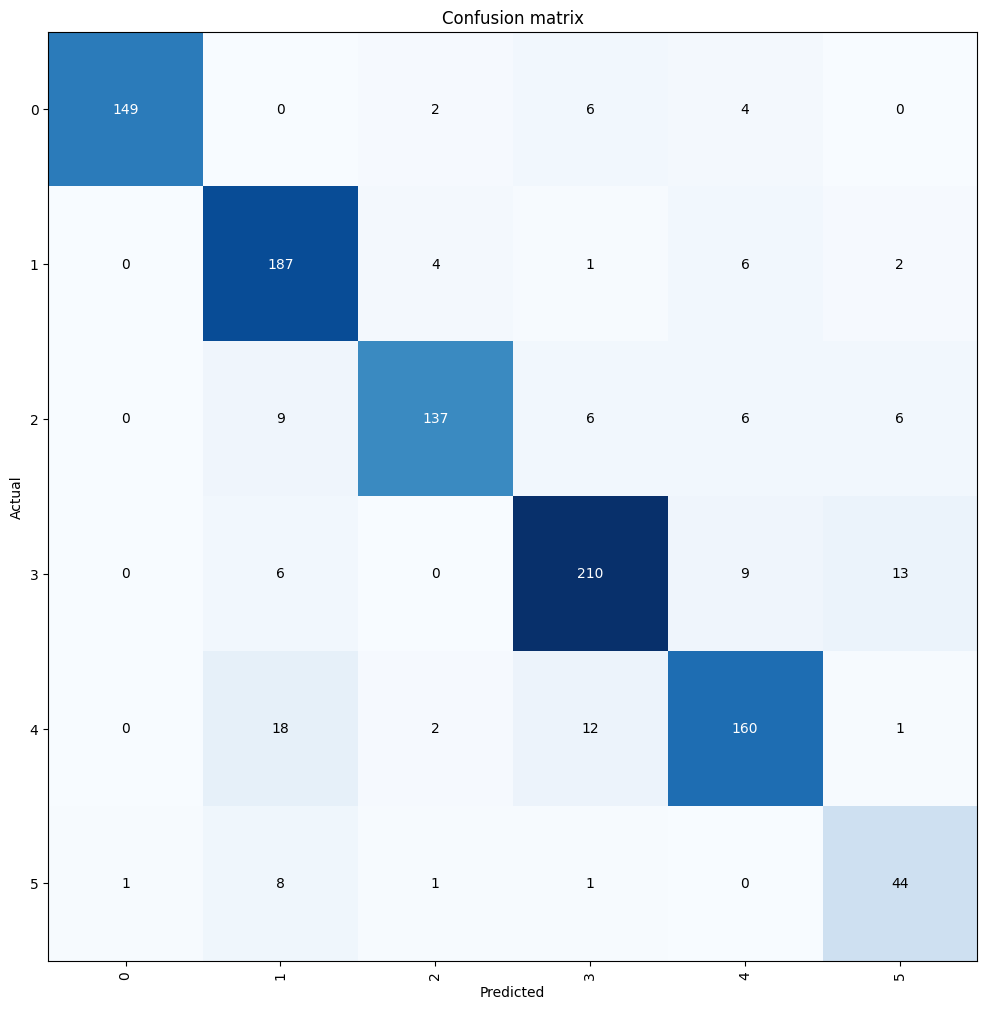

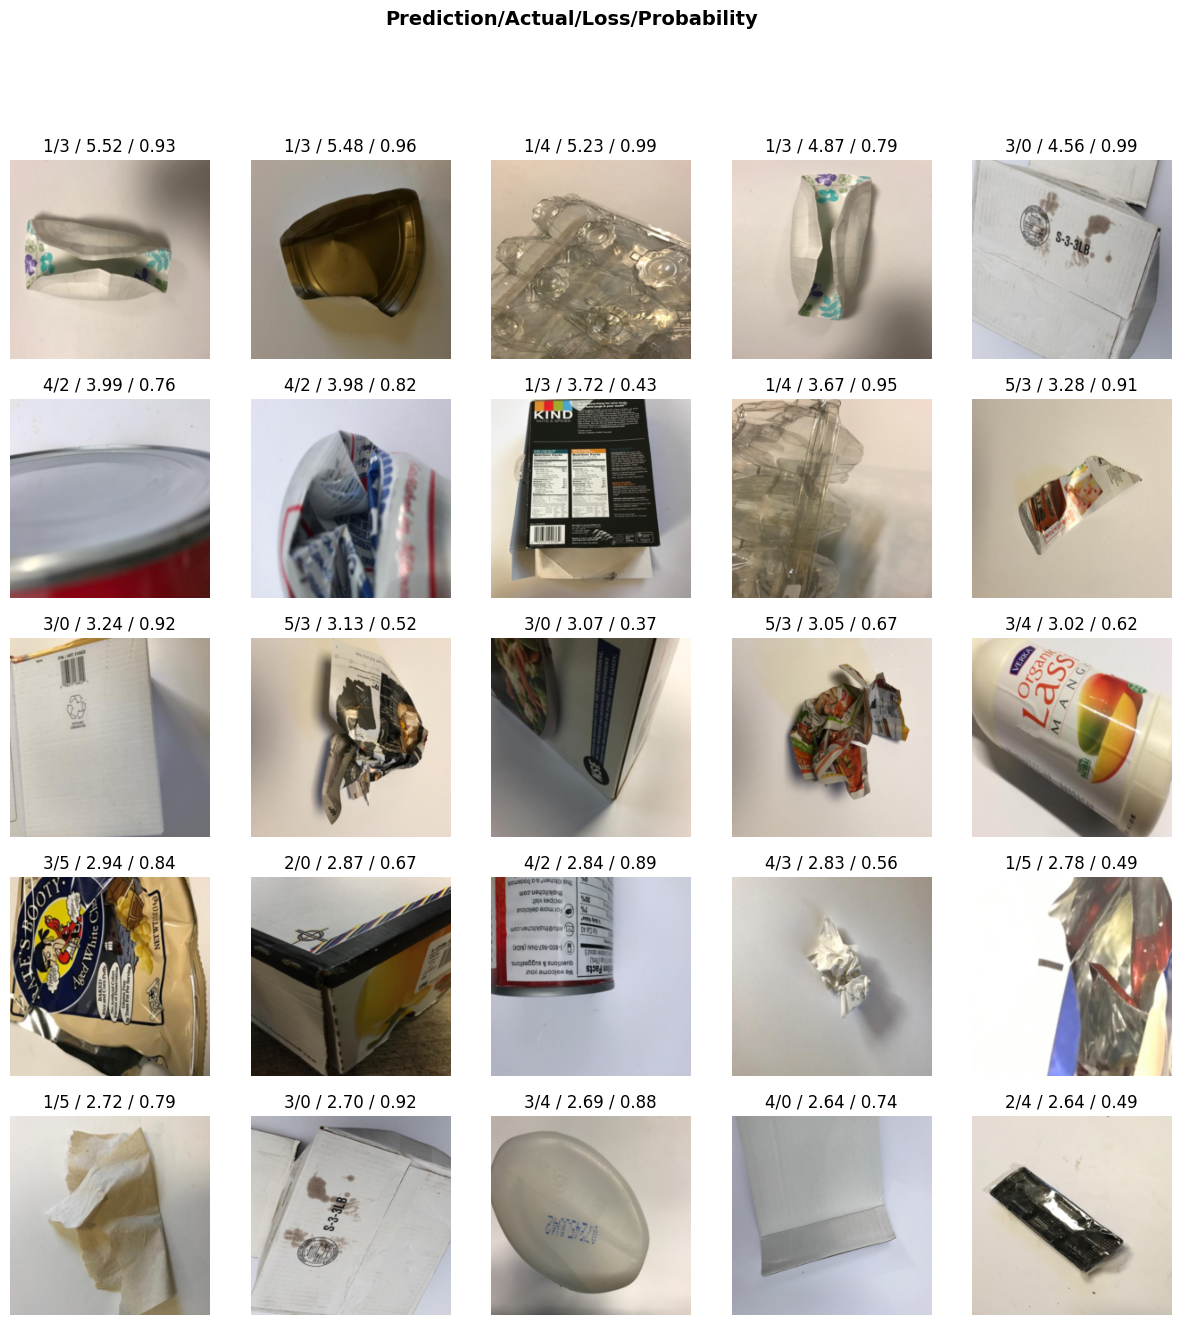

In [35]:
evaluate(learner_resnet34)

Berdasarkan hasil evaluasi ini, kemampuan model memprediksi label 0 hanya salah 1 secara keseluruhan. Artinya hanya sedikit saja sampah dengan label 0 yang tidak terdeteksi.
Di lain sisi, kemampuan model memprediksi sampah dengan label 5 cukup buruk, yang mana nilai precisionnya sampai menyentuh 60an. Isu ini kemungkinan besar dikarenakan data yang cukup sedikit pada jenis sampah ini dalam pelatihan.

Kemudian, pada contoh kesalahan prediksi di atas, ada prediksi yang tertukar antara sampah label 5 dan 3. Yang mana label 3 diprediksi sebagai label 5 dan sebaliknya (citra baris 3 kolom 4 dan baris 4 kolom 1). Jenis sampah ini jika dilihat secara seksama memanglah sangat mirip baik dari segi bentuk maupun warna. Hal inilah yang menjadi alasan lain buruknya performa prediksi label 5.

In [36]:
wandb.finish()

Summary learner,ResNet (Input shape:...
